In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from math import log
from ta.trend import ADXIndicator
from functools import partial

In [2]:
stock='ACC'
startdate='2007-01-01'
enddate='2022-01-01'
exchange=['.NS','.BO']
dfo = yf.download(stock+exchange[0],start=startdate)

[*********************100%***********************]  1 of 1 completed


In [3]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas.plotting._matplotlib.style import get_standard_colors

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = get_standard_colors(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)], **kwargs)
        ax_new.set_ylabel(ylabel=cols[n])
        
        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [4]:
df=dfo.copy()

In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,1096.000000,1096.900024,1083.099976,1092.949951,804.138306,261173
2007-01-03,1080.000000,1104.400024,1067.000000,1073.599976,789.901672,429012
2007-01-04,1083.500000,1089.800049,1064.000000,1071.800049,788.577332,448277
2007-01-05,1080.000000,1080.000000,1045.099976,1054.699951,775.996033,319430
2007-01-08,1055.000000,1059.949951,1020.049988,1028.650024,756.829834,311429
...,...,...,...,...,...,...
2022-01-20,2230.000000,2285.250000,2230.000000,2254.000000,2254.000000,322553
2022-01-21,2240.000000,2255.899902,2196.000000,2215.750000,2215.750000,238038
2022-01-24,2210.000000,2219.649902,2148.350098,2167.449951,2167.449951,467114


In [6]:
leng=80
fast=19
slow=3

In [7]:
df['price']=(df['High']+df['Low'])/2

In [8]:
def rwema(window,alpha,df,field):
    weights=list(reversed([(1-alpha)**n for n in range(window)]))
    ewma = partial(np.average, weights=weights)
    df['RWEMA'] = df[field].rolling(window).apply(ewma)
    df.replace(to_replace=np.nan,value=0,inplace=True)
    return df

In [9]:
window=50     #10 for week , 50 Days
alpha=0.1
field='Close'
df=rwema(window,alpha,df,field)

In [28]:
df

,Open,High,Low,Close,Adj Close,Volume,price,RWEMA,change,H1,...,dimen1,ER,adx,adxplus,adxminus,hl,hc,lc,tr,trur
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-02,1096.000000,1096.900024,1083.099976,1092.949951,804.138306,261173,1090.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.800049,0.000000,0.000000,13.800049,0.000000
2007-01-03,1080.000000,1104.400024,1067.000000,1073.599976,789.901672,429012,1085.700012,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,37.400024,11.450073,25.949951,37.400024,0.000000
2007-01-04,1083.500000,1089.800049,1064.000000,1071.800049,788.577332,448277,1076.900024,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,25.800049,16.200073,9.599976,25.800049,0.000000
2007-01-05,1080.000000,1080.000000,1045.099976,1054.699951,775.996033,319430,1062.549988,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,34.900024,8.199951,26.700073,34.900024,0.000000
2007-01-08,1055.000000,1059.949951,1020.049988,1028.650024,756.829834,311429,1039.999969,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,39.899963,5.250000,34.649963,39.899963,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-20,2230.000000,2285.250000,2230.000000,2254.000000,2254.000000,322553,2257.625000,2267.488159,59.000000,2392.899902,...,1.585442,0.585442,23.369473,21.778360,18.045697,55.250000,53.449951,1.800049,55.250000,65.772125
2022-01-21,2240.000000,2255.899902,2196.000000,2215.750000,2215.750000,238038,2225.949951,2262.136937,96.025024,2392.899902,...,1.585442,0.585442,21.548320,19.664550,21.803443,59.899902,1.899902,58.000000,59.899902,65.615004
2022-01-24,2210.000000,2219.649902,2148.350098,2167.449951,2167.449951,467114,2184.000000,2252.458689,85.225098,2392.899902,...,1.585442,0.585442,21.535045,17.427410,26.925934,71.299805,3.899902,67.399902,71.299805,66.865718


In [10]:
df['change']=abs(df['price']-df['price'].shift(leng))

In [11]:
df.replace(to_replace=np.nan,value=0,inplace=True)

In [12]:
leng1=int(leng/2)
df['H1']=df['High'].rolling(leng1).max()
df['L1']=df['Low'].rolling(leng1).min()
df['N1']=(df['H1']-df['L1'])/leng1


In [13]:
df['H2']=(df['High'].rolling(leng).max()).shift(leng1)
df['L2']=(df['Low'].rolling(leng).min()).shift(leng1)
df['N2']=(df['H2']-df['L2'])/leng1

In [14]:
df['H3']=df['High'].rolling(leng).max()
df['L3']=df['Low'].rolling(leng).min()
df['N3']=(df['H3']-df['L3'])/leng

In [15]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,price,RWEMA,change,H1,L1,N1,H2,L2,N2,H3,L3,N3
Date,,,,,,,,,,,,,,,,,,
2022-01-20,2230.000000,2285.250000,2230.000000,2254.000000,2254.000000,322553,2257.625000,2267.488159,59.000000,2392.899902,2087.800049,7.627496,2589.0,2142.050049,11.173749,2589.0,2087.800049,6.264999
2022-01-21,2240.000000,2255.899902,2196.000000,2215.750000,2215.750000,238038,2225.949951,2262.136937,96.025024,2392.899902,2087.800049,7.627496,2589.0,2142.050049,11.173749,2589.0,2087.800049,6.264999
2022-01-24,2210.000000,2219.649902,2148.350098,2167.449951,2167.449951,467114,2184.000000,2252.458689,85.225098,2392.899902,2087.800049,7.627496,2589.0,2142.050049,11.173749,2589.0,2087.800049,6.264999
2022-01-25,2160.100098,2192.600098,2120.050049,2179.949951,2179.949951,262179,2156.325073,2245.009325,107.724854,2392.899902,2087.800049,7.627496,2589.0,2142.050049,11.173749,2589.0,2087.800049,6.264999
2022-01-27,2156.000000,2179.000000,2127.649902,2167.699951,2167.699951,298171,2153.324951,2237.109996,81.350098,2392.899902,2087.800049,7.627496,2589.0,2142.050049,11.173749,2589.0,2087.800049,6.264999


<AxesSubplot:xlabel='Date'>

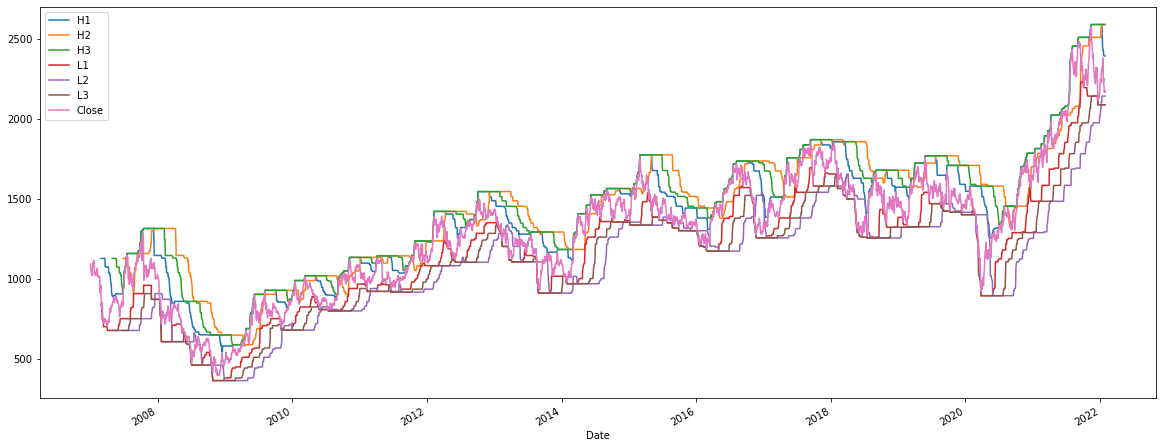

In [16]:
df[['H1','H2','H3','L1','L2','L3','Close']].plot(figsize=(20,8))

In [17]:
df['dimen1'] = (np.log(df['N1']+df['N2'])-np.log(df['N3']))/np.log(leng/leng1)

<AxesSubplot:xlabel='Date', ylabel='Close'>

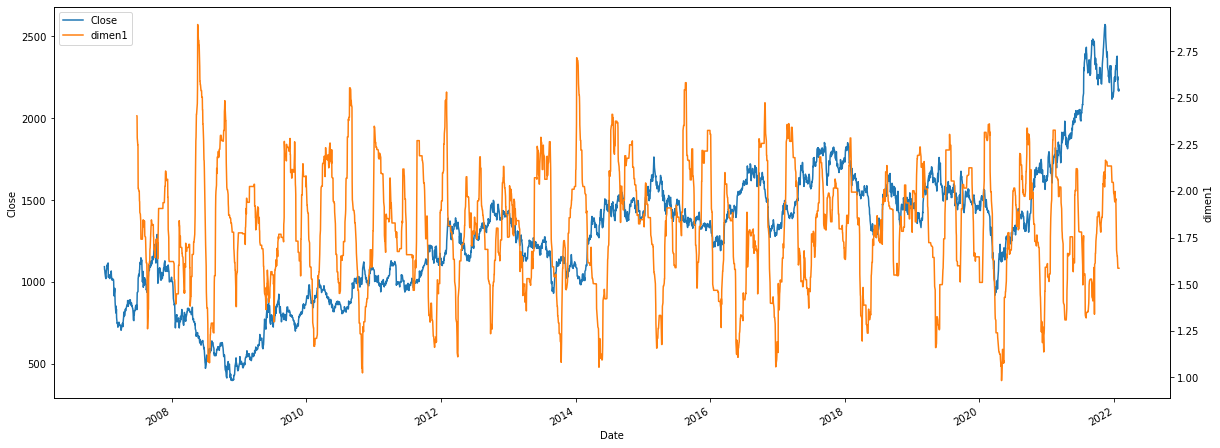

In [18]:
data =df[['Close','dimen1',]]
plot_multi(data, figsize=(20, 8))

In [19]:
df['ER']=abs(df['dimen1']-1)

<AxesSubplot:xlabel='Date'>

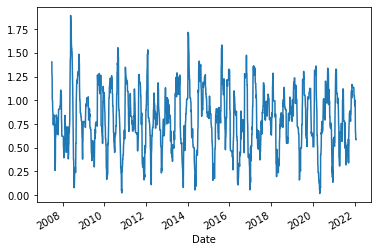

In [20]:
df['ER'].plot()

In [21]:
adx_output=ADXIndicator(high=df['High'],low=df['Low'],close=df['Close'],window=10,fillna=True)

In [22]:
df['adx']=adx_output.adx()
df['adxplus']=adx_output.adx_pos()
df['adxminus']=adx_output.adx_neg()

C:\anaconda\envs\market38\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\anaconda\envs\market38\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [23]:
df

,Open,High,Low,Close,Adj Close,Volume,price,RWEMA,change,H1,...,L2,N2,H3,L3,N3,dimen1,ER,adx,adxplus,adxminus
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-02,1096.000000,1096.900024,1083.099976,1092.949951,804.138306,261173,1090.000000,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2007-01-03,1080.000000,1104.400024,1067.000000,1073.599976,789.901672,429012,1085.700012,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2007-01-04,1083.500000,1089.800049,1064.000000,1071.800049,788.577332,448277,1076.900024,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2007-01-05,1080.000000,1080.000000,1045.099976,1054.699951,775.996033,319430,1062.549988,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2007-01-08,1055.000000,1059.949951,1020.049988,1028.650024,756.829834,311429,1039.999969,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-20,2230.000000,2285.250000,2230.000000,2254.000000,2254.000000,322553,2257.625000,2267.488159,59.000000,2392.899902,...,2142.050049,11.173749,2589.0,2087.800049,6.264999,1.585442,0.585442,23.369473,21.778360,18.045697
2022-01-21,2240.000000,2255.899902,2196.000000,2215.750000,2215.750000,238038,2225.949951,2262.136937,96.025024,2392.899902,...,2142.050049,11.173749,2589.0,2087.800049,6.264999,1.585442,0.585442,21.548320,19.664550,21.803443
2022-01-24,2210.000000,2219.649902,2148.350098,2167.449951,2167.449951,467114,2184.000000,2252.458689,85.225098,2392.899902,...,2142.050049,11.173749,2589.0,2087.800049,6.264999,1.585442,0.585442,21.535045,17.427410,26.925934


In [24]:
df['hl']=df['High']-df['Low']
df['hc']=abs(df['High']-df['Close'].shift(1))
df['lc']=abs(df['Low']-df['Close'].shift(1))
df.replace(to_replace=np.nan,value=0,inplace=True)

In [25]:
df['tr']=df[['hl','hc','lc']].T.max()

In [26]:
from functools import partial
window=14
alpha=0.1
weights=list(reversed([(1-alpha)**n for n in range(window)]))
ewma = partial(np.average, weights=weights)
df['trur'] = df['tr'].rolling(window).apply(ewma)
df.replace(to_replace=np.nan,value=0,inplace=True)

In [27]:
df

,Open,High,Low,Close,Adj Close,Volume,price,RWEMA,change,H1,...,dimen1,ER,adx,adxplus,adxminus,hl,hc,lc,tr,trur
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-02,1096.000000,1096.900024,1083.099976,1092.949951,804.138306,261173,1090.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.800049,0.000000,0.000000,13.800049,0.000000
2007-01-03,1080.000000,1104.400024,1067.000000,1073.599976,789.901672,429012,1085.700012,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,37.400024,11.450073,25.949951,37.400024,0.000000
2007-01-04,1083.500000,1089.800049,1064.000000,1071.800049,788.577332,448277,1076.900024,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,25.800049,16.200073,9.599976,25.800049,0.000000
2007-01-05,1080.000000,1080.000000,1045.099976,1054.699951,775.996033,319430,1062.549988,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,34.900024,8.199951,26.700073,34.900024,0.000000
2007-01-08,1055.000000,1059.949951,1020.049988,1028.650024,756.829834,311429,1039.999969,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,39.899963,5.250000,34.649963,39.899963,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-20,2230.000000,2285.250000,2230.000000,2254.000000,2254.000000,322553,2257.625000,2267.488159,59.000000,2392.899902,...,1.585442,0.585442,23.369473,21.778360,18.045697,55.250000,53.449951,1.800049,55.250000,65.772125
2022-01-21,2240.000000,2255.899902,2196.000000,2215.750000,2215.750000,238038,2225.949951,2262.136937,96.025024,2392.899902,...,1.585442,0.585442,21.548320,19.664550,21.803443,59.899902,1.899902,58.000000,59.899902,65.615004
2022-01-24,2210.000000,2219.649902,2148.350098,2167.449951,2167.449951,467114,2184.000000,2252.458689,85.225098,2392.899902,...,1.585442,0.585442,21.535045,17.427410,26.925934,71.299805,3.899902,67.399902,71.299805,66.865718
